## Importar librerías

In [3]:
# !pip install imblearn
# !pip install prettytable

In [71]:
import pandas as pd
import numpy as np

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier

from prettytable import PrettyTable
from matplotlib import pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

## Importar Dataset preprocesado

In [14]:
df = pd.read_pickle('dataset_treated.pkl')

## Preparación de datos

### Separación en sets de testeo y entrenamiento

In [17]:
X = df.copy()
X = X.drop('oid', axis=1)
X = X.drop('classALeRCE', axis=1)
y = df['classALeRCE']
test_size = 0.2

random_state = 15

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify = y)

### Utilizar features obtenidas de BRF

In [18]:
brf_best_col = ['delta_mjd_fid_g', 'first_mag_g', 'delta_mjd_fid_r', 'first_mag_r',
                'min_mag_r', 'MHPS_ratio_g', 'MHPS_low_g', 'MHPS_high_g',
                'GP_DRW_tau_g', 'GP_DRW_sigma_r', 'Power_rate_4', 'Std_g', 'IAR_phi_g',
                'LinearTrend_g', 'AndersonDarling_r', 'MedianAbsDev_r',
                'PairSlopeTrend_r', 'Q31_r', 'Std_r', 'LinearTrend_r', 'SPM_t0_g',
                'SPM_gamma_g', 'SPM_tau_rise_g', 'SPM_tau_fall_g', 'SPM_A_r',
                'SPM_t0_r', 'SPM_gamma_r', 'SPM_beta_r', 'SPM_tau_rise_r',
                'SPM_tau_fall_r']

In [19]:
X_train = X_train[brf_best_col]
X_test = X_test[brf_best_col]

## Tunning de modelos

### Balanced Random Forest

In [21]:
hyperparameter_score_list = []
for estimators in [200, 300, 400, 500]:
    for depth in range(3,15):
        for features in ['sqrt', 'log2']:
            brfc = BalancedRandomForestClassifier(sampling_strategy = 'all', 
                                                  replacement = True,
                                                  n_estimators = estimators, max_depth = depth, max_features = features, random_state=0)
            scores = cross_validate(brfc, X_train, y_train, cv=5, scoring='recall_macro')
            mean_score = np.mean(scores['test_score'])
            hyperparameter_score_list.append([estimators, depth, features, mean_score])

In [22]:
myTable = PrettyTable(['estimators', 'depth', 'features', 'avg macro-recall'])
for row in hyperparameter_score_list:
    myTable.add_row([row[0], row[1], row[2], round(row[3],3)])
print(myTable)

+------------+-------+----------+------------------+
| estimators | depth | features | avg macro-recall |
+------------+-------+----------+------------------+
|    200     |   3   |   sqrt   |      0.595       |
|    200     |   3   |   log2   |      0.583       |
|    200     |   4   |   sqrt   |      0.614       |
|    200     |   4   |   log2   |      0.574       |
|    200     |   5   |   sqrt   |      0.605       |
|    200     |   5   |   log2   |      0.585       |
|    200     |   6   |   sqrt   |      0.623       |
|    200     |   6   |   log2   |      0.619       |
|    200     |   7   |   sqrt   |      0.626       |
|    200     |   7   |   log2   |       0.61       |
|    200     |   8   |   sqrt   |      0.614       |
|    200     |   8   |   log2   |      0.616       |
|    200     |   9   |   sqrt   |      0.611       |
|    200     |   9   |   log2   |      0.614       |
|    200     |   10  |   sqrt   |       0.61       |
|    200     |   10  |   log2   |      0.618  

In [23]:
max_hyper = [0, 0]
for i in range(len(hyperparameter_score_list)):
    if hyperparameter_score_list[i][3] > max_hyper[1]:
        max_hyper[1] = hyperparameter_score_list[i][3]
        max_hyper[0] = i
        print(hyperparameter_score_list[i])

[200, 3, 'sqrt', 0.5948609803021135]
[200, 4, 'sqrt', 0.6141232409372357]
[200, 6, 'sqrt', 0.6225318267254395]
[200, 7, 'sqrt', 0.6259754386686881]
[300, 6, 'sqrt', 0.6262990089484266]
[400, 6, 'sqrt', 0.631446686201503]


In [32]:
clf = BalancedRandomForestClassifier(sampling_strategy="all", replacement=True, random_state=513, n_estimators = 400, max_depth = 6, max_features = 'sqrt')
clf.fit(X_train, y_train)

BalancedRandomForestClassifier(max_depth=6, n_estimators=400, random_state=513,
                               replacement=True, sampling_strategy='all')

In [33]:
y_pred = clf.predict(X_test)

**Reporte de metricas**

In [35]:
print(classification_report(y_test, y_pred, target_names = clf.classes_))

              precision    recall  f1-score   support

        SLSN       0.35      1.00      0.52         7
        SNII       0.81      0.64      0.72        73
        SNIa       0.92      0.77      0.84       286
       SNIbc       0.13      0.50      0.21        18

    accuracy                           0.74       384
   macro avg       0.55      0.73      0.57       384
weighted avg       0.86      0.74      0.78       384



**Matriz de confusion**

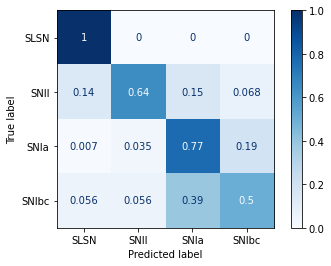

In [36]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues, normalize="true")

### KNN

In [37]:
hyperparameter_score_list2 = []
for p in range(1,4):
    for neighbor in range(2,10):
        for weight in ['uniform', 'distance']:
            for algorithm in ['ball_tree', 'kd_tree']:
                knn = KNeighborsClassifier(p=p, n_neighbors=neighbor, weights = weight,  algorithm = algorithm)
                scores = cross_validate(brfc, X_train, y_train, cv=5, scoring='recall_macro')
                mean_score = np.mean(scores['test_score'])
                hyperparameter_score_list2.append([p, neighbor, weight, algorithm, mean_score])

In [38]:
hyperparameter_score_list2[:3]

[[1, 2, 'uniform', 'ball_tree', 0.6138778022093133],
 [1, 2, 'uniform', 'kd_tree', 0.6138778022093133],
 [1, 2, 'distance', 'ball_tree', 0.6138778022093133]]

In [39]:
myTable2 = PrettyTable(['p', 'neighbor', 'weight', 'algorithm', 'avg macro-recall'])
for row in hyperparameter_score_list2:
    myTable2.add_row([row[0], row[1], row[2], row[3], round(row[4],3)])
print(myTable2)

+---+----------+----------+-----------+------------------+
| p | neighbor |  weight  | algorithm | avg macro-recall |
+---+----------+----------+-----------+------------------+
| 1 |    2     | uniform  | ball_tree |      0.614       |
| 1 |    2     | uniform  |  kd_tree  |      0.614       |
| 1 |    2     | distance | ball_tree |      0.614       |
| 1 |    2     | distance |  kd_tree  |      0.614       |
| 1 |    3     | uniform  | ball_tree |      0.614       |
| 1 |    3     | uniform  |  kd_tree  |      0.614       |
| 1 |    3     | distance | ball_tree |      0.614       |
| 1 |    3     | distance |  kd_tree  |      0.614       |
| 1 |    4     | uniform  | ball_tree |      0.614       |
| 1 |    4     | uniform  |  kd_tree  |      0.614       |
| 1 |    4     | distance | ball_tree |      0.614       |
| 1 |    4     | distance |  kd_tree  |      0.614       |
| 1 |    5     | uniform  | ball_tree |      0.614       |
| 1 |    5     | uniform  |  kd_tree  |      0.614      

In [41]:
max_hyper2 = [0, 0]
for i in range(len(hyperparameter_score_list2)):
    if hyperparameter_score_list2[i][4] > max_hyper2[1]:
        max_hyper2[1] = hyperparameter_score_list2[i][4]
        max_hyper2[0] = i
        print(hyperparameter_score_list2[i])

[1, 2, 'uniform', 'ball_tree', 0.6138778022093133]


In [43]:
clf2 = KNeighborsClassifier(p=1, n_neighbors=2, weights = 'uniform',  algorithm = 'ball_tree')

clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)

In [44]:
print(classification_report(y_test, y_pred, target_names = clf2.classes_))

              precision    recall  f1-score   support

        SLSN       0.15      0.29      0.20         7
        SNII       0.56      0.64      0.60        73
        SNIa       0.89      0.89      0.89       286
       SNIbc       1.00      0.06      0.11        18

    accuracy                           0.79       384
   macro avg       0.65      0.47      0.45       384
weighted avg       0.82      0.79      0.79       384



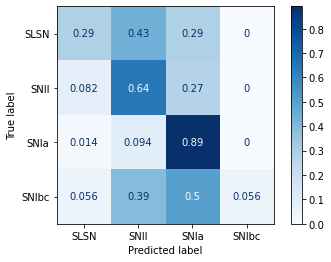

In [45]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues, normalize="true")

### GBoost

#### Undersampling

In [77]:
rus = RandomUnderSampler(random_state=513)
X_res, y_res = rus.fit_resample(X, y)

In [80]:
rus = RandomUnderSampler(random_state=513)
X_res, y_res = rus.fit_resample(X, y)
test_size = 0.2
random_state = 15

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=test_size, random_state=random_state, stratify = y_res)
X_train = X_train[brf_best_col]
X_test = X_test[brf_best_col]

In [81]:
hyperparameter_score_list3 = []

for estimators in [200, 300, 400, 500]:
    for depth in range(3,15):
        for features in ['sqrt', 'log2']:
            gbc = GradientBoostingClassifier(n_estimators = estimators, max_depth = depth, max_features = features, random_state=0)
            scores = cross_validate(gbc, X_train, y_train, cv=5, scoring='recall_macro')
            mean_score = np.mean(scores['test_score'])
            hyperparameter_score_list3.append([estimators, depth, features, mean_score])

In [82]:
myTable3 = PrettyTable(['estimators', 'depth', 'features', 'avg macro-recall'])
for row in hyperparameter_score_list3:
    myTable3.add_row([row[0], row[1], row[2], round(row[3],3)])
print(myTable3)

+------------+-------+----------+------------------+
| estimators | depth | features | avg macro-recall |
+------------+-------+----------+------------------+
|    200     |   3   |   sqrt   |      0.605       |
|    200     |   3   |   log2   |      0.587       |
|    200     |   4   |   sqrt   |      0.615       |
|    200     |   4   |   log2   |      0.595       |
|    200     |   5   |   sqrt   |      0.613       |
|    200     |   5   |   log2   |      0.622       |
|    200     |   6   |   sqrt   |      0.583       |
|    200     |   6   |   log2   |       0.6        |
|    200     |   7   |   sqrt   |      0.578       |
|    200     |   7   |   log2   |      0.602       |
|    200     |   8   |   sqrt   |      0.603       |
|    200     |   8   |   log2   |      0.602       |
|    200     |   9   |   sqrt   |      0.593       |
|    200     |   9   |   log2   |       0.6        |
|    200     |   10  |   sqrt   |      0.573       |
|    200     |   10  |   log2   |      0.583  

In [83]:
max_hyper3 = [0, 0]
for i in range(len(hyperparameter_score_list3)):
    if hyperparameter_score_list3[i][3] > max_hyper3[1]:
        max_hyper3[1] = hyperparameter_score_list3[i][3]
        max_hyper3[0] = i
        print(hyperparameter_score_list3[i])

[200, 3, 'sqrt', 0.605]
[200, 4, 'sqrt', 0.615]
[200, 5, 'log2', 0.6216666666666667]


In [87]:
clf3 = GradientBoostingClassifier(n_estimators = 200, max_depth = 5, max_features = 'log2', random_state=513)
clf3.fit(X_train, y_train)
y_pred = clf3.predict(X_test)

In [88]:
print(classification_report(y_test, y_pred, target_names = clf3.classes_))

              precision    recall  f1-score   support

        SLSN       0.78      1.00      0.88         7
        SNII       0.75      0.43      0.55         7
        SNIa       0.67      0.86      0.75         7
       SNIbc       0.50      0.43      0.46         7

    accuracy                           0.68        28
   macro avg       0.67      0.68      0.66        28
weighted avg       0.67      0.68      0.66        28



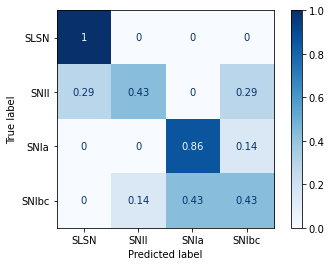

In [89]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues, normalize="true")

#### Oversampling

In [90]:
ros = RandomOverSampler(random_state=513)
X_ros, y_ros = ros.fit_resample(X, y)
test_size = 0.2
random_state = 15

X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=test_size, random_state=random_state, stratify = y_ros)
X_train = X_train[brf_best_col]
X_test = X_test[brf_best_col]

In [91]:
hyperparameter_score_list3 = []

for estimators in [200, 300, 400, 500]:
    for depth in range(3,15):
        for features in ['sqrt', 'log2']:
            gbc = GradientBoostingClassifier(n_estimators = estimators, max_depth = depth, max_features = features, random_state=0)
            scores = cross_validate(gbc, X_train, y_train, cv=5, scoring='recall_macro')
            mean_score = np.mean(scores['test_score'])
            hyperparameter_score_list3.append([estimators, depth, features, mean_score])

In [92]:
myTable3 = PrettyTable(['estimators', 'depth', 'features', 'avg macro-recall'])
for row in hyperparameter_score_list3:
    myTable3.add_row([row[0], row[1], row[2], round(row[3],3)])
print(myTable3)

+------------+-------+----------+------------------+
| estimators | depth | features | avg macro-recall |
+------------+-------+----------+------------------+
|    200     |   3   |   sqrt   |      0.976       |
|    200     |   3   |   log2   |      0.975       |
|    200     |   4   |   sqrt   |      0.985       |
|    200     |   4   |   log2   |      0.984       |
|    200     |   5   |   sqrt   |      0.987       |
|    200     |   5   |   log2   |      0.987       |
|    200     |   6   |   sqrt   |      0.988       |
|    200     |   6   |   log2   |      0.988       |
|    200     |   7   |   sqrt   |      0.989       |
|    200     |   7   |   log2   |      0.989       |
|    200     |   8   |   sqrt   |       0.99       |
|    200     |   8   |   log2   |       0.99       |
|    200     |   9   |   sqrt   |      0.991       |
|    200     |   9   |   log2   |       0.99       |
|    200     |   10  |   sqrt   |      0.991       |
|    200     |   10  |   log2   |      0.992  

**CAMBIAR SEGUN OPTIMO**

In [94]:
max_hyper3 = [0, 0]
for i in range(len(hyperparameter_score_list3)):
    if hyperparameter_score_list3[i][3] > max_hyper3[1]:
        max_hyper3[1] = hyperparameter_score_list3[i][3]
        max_hyper3[0] = i
        print(hyperparameter_score_list3[i])

[200, 3, 'sqrt', 0.9755553445984431]
[200, 4, 'sqrt', 0.985374026960319]
[200, 5, 'sqrt', 0.9869033605468008]
[200, 5, 'log2', 0.9873400417695082]
[200, 6, 'sqrt', 0.9884288969052593]
[200, 7, 'sqrt', 0.9893022593506741]
[200, 8, 'sqrt', 0.9901756217960888]
[200, 9, 'sqrt', 0.9908296943231442]
[200, 10, 'sqrt', 0.9910489842415038]
[200, 10, 'log2', 0.9919223466869184]


In [96]:
clf3 = GradientBoostingClassifier(n_estimators = 200, max_depth = 10, max_features = 'log2', random_state=513)
clf3.fit(X_train, y_train)
y_pred = clf3.predict(X_test)

In [97]:
print(classification_report(y_test, y_pred, target_names = clf3.classes_))

              precision    recall  f1-score   support

        SLSN       1.00      1.00      1.00       287
        SNII       0.98      1.00      0.99       287
        SNIa       1.00      0.98      0.99       286
       SNIbc       1.00      1.00      1.00       286

    accuracy                           1.00      1146
   macro avg       1.00      1.00      1.00      1146
weighted avg       1.00      1.00      1.00      1146



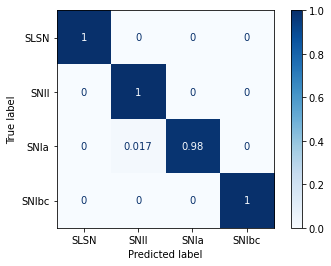

In [98]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues, normalize="true")